In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np

from library.evaluation import ConfusionMatrix

random.seed(37)

unique_name = "RoBERTa"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr1_RoBERTa_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(5802, 768)

In [3]:
phemernr = pd.read_csv("../../data/processed/phemernr1_dataset_with_tvt.csv", lineterminator="\n")
phemernr.head()

,tweet_text,topic,label,tvt,cv_fold
0,BOMBSHELL: #Ferguson chief says the police off...,ferguson,rumours,test,3
1,It appears that #Ferguson PD are trying to ass...,ferguson,rumours,training,1
2,"All weekend ppl will be talking about the ""rob...",ferguson,rumours,test,3
3,Why would the officer tell #MikeBrown to get o...,ferguson,rumours,test,3
4,Michael Brown is the 17 yr old boy who was sho...,ferguson,rumours,training,0


In [4]:
labels = []
for i, p2 in phemernr.iterrows():
    if p2['label'] == 'rumours':
        labels.append([0])
    elif p2['label'] == 'non-rumours':
        labels.append([1])
    else:
        labels.append(None)
labels[:10]

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [5]:
train_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_vectors = np.array([vectors[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

train_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'training'])
val_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'validation'])
test_labels = np.array([labels[i] for i, p2 in phemernr.iterrows() if p2['tvt'] == 'test'])

In [6]:
label_tag = ['rumours', 'non-rumours']
label_tag

['rumours', 'non-rumours']

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

print("Class 0 : ", len([i for i in test_labels if i == 0]))
print("Class 1 : ", len([i for i in test_labels if i == 1]))

(3498, 768)
(1150, 768)
(1154, 768)
(3498, 1)
(1150, 1)
(1154, 1)
Class 0 :  381
Class 1 :  773


In [8]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(val_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([1175, 2323]))
(array([0, 1]), array([416, 734]))
(array([0, 1]), array([381, 773]))


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)
        self.final = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.final(out)
        return out


def ResNet10(n_input=768, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input)

    
def ResNet18(n_input=768, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input)


def ResNet34(n_input=768, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input)


def ResNet50(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input)


def ResNet101(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input)


def ResNet152(n_input=768, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)
        self.final = nn.Sigmoid()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.final(out)
        return out


def CNNResNet10():
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1])

    
def CNNResNet18():
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2])


def CNNResNet34():
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3])


def CNNResNet50():
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3])


def CNNResNet101():
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3])


def CNNResNet152():
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3])

In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
#                 for i, output in enumerate(outputs.tolist()):
#                     if targets[i,0].tolist() == round(output[0]):
#                         correct += 1

#             train_acc = round(100*correct/total, 4)
#             train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                
                if self.model_type == 'mlp':
                    outputs = self.model(inputs)
                else:
                    outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                
                loss = self.criterion(outputs, targets)
                try:
                    outputs = self.model(inputs.unsqueeze(1))
                except Exception:
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)
                test_loss += loss.item()
                
                if self.model_type == 'mlp':
                    preds = self.predict(test_x)
                else:
                    preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                conf_mat = ConfusionMatrix(
                    labels=test_y,
                    predictions=[p[0] for p in preds.cpu().numpy()],
                    binary=True
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.Tensor(input_x))

Multiclass Classification Phemernr1_ResNet10_MLP_RoBERTa
Using cuda
Saving after new best accuracy : 63.826
Saving after new best accuracy : 64.087
Saving after new best accuracy : 64.783
Saving after new best accuracy : 65.043
Saving after new best accuracy : 70.609
Saving after new best accuracy : 73.913
Saving after new best accuracy : 75.304
Saving after new best accuracy : 80.0
Saving after new best accuracy : 80.261
-- Epoch 50, Train Loss : 0.2736637815833092, Test Loss : 0.49027058482170105
Saving after new best accuracy : 80.348
Saving after new best accuracy : 81.391
-- Epoch 100, Train Loss : 0.1395683754235506, Test Loss : 0.4765262007713318
-- Epoch 150, Train Loss : 0.07510385639034212, Test Loss : 0.5236166715621948
-- Epoch 200, Train Loss : 0.048993145348504186, Test Loss : 0.5609538555145264
-- Epoch 250, Train Loss : 0.034156126726884395, Test Loss : 0.5920599102973938
-- Epoch 300, Train Loss : 0.025071882759220898, Test Loss : 0.6166055798530579
-- Epoch 350, Train

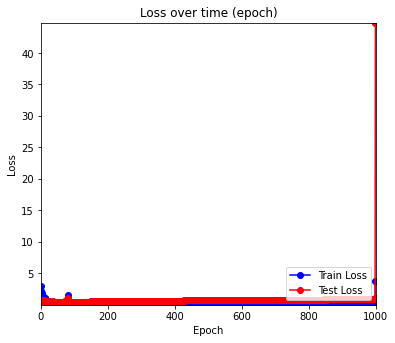


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 650
False Positive : 130
False Negative : 84
True Negative : 286

Class positive Evaluation
- Precision : 83.333 %
- Recall : 88.556 %
- F1 : 0.85865

Class negative Evaluation
- Precision : 77.297 %
- Recall : 68.75 %
- F1 : 0.72774

Combined Evaluation
- Accuracy : 81.391 %
- Precision : 80.315 %
- Recall : 78.653 %
- F1 : 0.79475
- Average Confidence : 70.4 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet10_MLP_RoBERTa, 81.391, 80.315, 78.653, 0.79475, 83.333, 88.556, 0.85865, 77.297, 68.75, 0.72774, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 681
False Positive : 127
False Negative : 92
True Negative : 254

Class positive Evaluation
- Precision : 84.282 %
- Recall : 88.098 %
- F1 : 0.86148

Class negative Evaluation
- Precision : 73.41 %
- Recall : 66.667 %
- F1 : 0.69876

Combined Evaluation
- Accuracy : 81.023 %
-

In [12]:
model_name = f"Phemernr1_ResNet10_MLP_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(ResNet10(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16) #, device="cpu")
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet18_MLP_RoBERTa
Using cuda
Saving after new best accuracy : 36.174
Saving after new best accuracy : 55.391
Saving after new best accuracy : 63.826
Saving after new best accuracy : 64.174
Saving after new best accuracy : 64.609
Saving after new best accuracy : 65.652
Saving after new best accuracy : 67.565
Saving after new best accuracy : 70.696
Saving after new best accuracy : 73.565
Saving after new best accuracy : 74.348
Saving after new best accuracy : 76.261
Saving after new best accuracy : 76.696
Saving after new best accuracy : 77.043
Saving after new best accuracy : 77.13
Saving after new best accuracy : 77.652
Saving after new best accuracy : 78.261
Saving after new best accuracy : 78.87
Saving after new best accuracy : 79.478
-- Epoch 50, Train Loss : 0.13790689036250114, Test Loss : 0.5236538052558899
Saving after new best accuracy : 79.913
Saving after new best accuracy : 80.0
Saving after new best accuracy : 80.087
Saving after new b

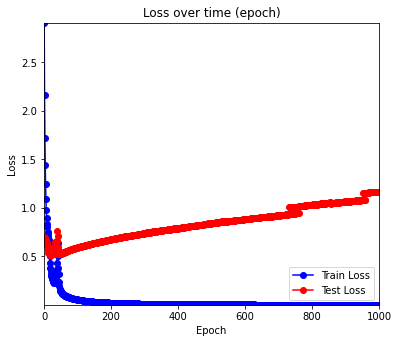


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 627
False Positive : 116
False Negative : 107
True Negative : 300

Class positive Evaluation
- Precision : 84.388 %
- Recall : 85.422 %
- F1 : 0.84902

Class negative Evaluation
- Precision : 73.71 %
- Recall : 72.115 %
- F1 : 0.72904

Combined Evaluation
- Accuracy : 80.609 %
- Precision : 79.049 %
- Recall : 78.769 %
- F1 : 0.78909
- Average Confidence : 76.89 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet18_MLP_RoBERTa, 80.609, 79.049, 78.769, 0.78909, 84.388, 85.422, 0.84902, 73.71, 72.115, 0.72904, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 645
False Positive : 129
False Negative : 128
True Negative : 252

Class positive Evaluation
- Precision : 83.333 %
- Recall : 83.441 %
- F1 : 0.83387

Class negative Evaluation
- Precision : 66.316 %
- Recall : 66.142 %
- F1 : 0.66229

Combined Evaluation
- Accuracy : 77.73 

In [13]:
model_name = f"Phemernr1_ResNet18_MLP_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(ResNet18(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16) #, device="cpu")
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet10_CNN_RoBERTa
Using cuda
Saving after new best accuracy : 63.826
Saving after new best accuracy : 64.261
Saving after new best accuracy : 67.043
Saving after new best accuracy : 69.391
Saving after new best accuracy : 72.261
Saving after new best accuracy : 74.087
Saving after new best accuracy : 75.565
Saving after new best accuracy : 76.348
Saving after new best accuracy : 77.043
Saving after new best accuracy : 77.478
Saving after new best accuracy : 77.652
Saving after new best accuracy : 77.739
Saving after new best accuracy : 77.826
Saving after new best accuracy : 78.348
Saving after new best accuracy : 78.435
Saving after new best accuracy : 78.609
Saving after new best accuracy : 78.696
Saving after new best accuracy : 78.783
Saving after new best accuracy : 78.87
Saving after new best accuracy : 79.043
Saving after new best accuracy : 79.217
Saving after new best accuracy : 79.304
Saving after new best accuracy : 79.391
Saving after 

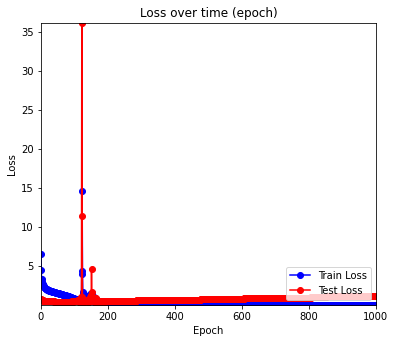


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 622
False Positive : 73
False Negative : 112
True Negative : 343

Class positive Evaluation
- Precision : 89.496 %
- Recall : 84.741 %
- F1 : 0.87054

Class negative Evaluation
- Precision : 75.385 %
- Recall : 82.452 %
- F1 : 0.7876

Combined Evaluation
- Accuracy : 83.913 %
- Precision : 82.441 %
- Recall : 83.597 %
- F1 : 0.83015
- Average Confidence : 78.36 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet10_CNN_RoBERTa, 83.913, 82.441, 83.597, 0.83015, 89.496, 84.741, 0.87054, 75.385, 82.452, 0.7876, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 659
False Positive : 81
False Negative : 114
True Negative : 300

Class positive Evaluation
- Precision : 89.054 %
- Recall : 85.252 %
- F1 : 0.87112

Class negative Evaluation
- Precision : 72.464 %
- Recall : 78.74 %
- F1 : 0.75472

Combined Evaluation
- Accuracy : 83.102 %


In [14]:
model_name = f"Phemernr1_ResNet10_CNN_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet10(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16, model_type="cnn") #, device="cpu")
model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

Multiclass Classification Phemernr1_ResNet18_CNN_RoBERTa
Using cuda
Saving after new best accuracy : 63.826
Saving after new best accuracy : 63.913
Saving after new best accuracy : 65.304
Saving after new best accuracy : 68.696
Saving after new best accuracy : 71.478
Saving after new best accuracy : 74.261
Saving after new best accuracy : 74.957
Saving after new best accuracy : 75.478
Saving after new best accuracy : 76.174
Saving after new best accuracy : 76.957
Saving after new best accuracy : 77.304
Saving after new best accuracy : 77.391
Saving after new best accuracy : 77.565
Saving after new best accuracy : 77.913
Saving after new best accuracy : 78.435
Saving after new best accuracy : 78.696
Saving after new best accuracy : 78.87
Saving after new best accuracy : 79.043
Saving after new best accuracy : 79.13
Saving after new best accuracy : 79.217
Saving after new best accuracy : 79.391
Saving after new best accuracy : 79.565
Saving after new best accuracy : 79.739
Saving after n

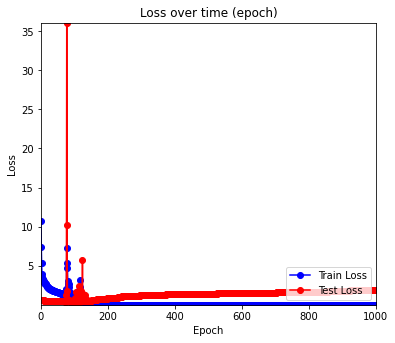


---- Validation Set ----
Predictions : torch.Size([1150, 1])
Binary Class Evaluation

True Positive : 631
False Positive : 85
False Negative : 103
True Negative : 331

Class positive Evaluation
- Precision : 88.128 %
- Recall : 85.967 %
- F1 : 0.87034

Class negative Evaluation
- Precision : 76.267 %
- Recall : 79.567 %
- F1 : 0.77882

Combined Evaluation
- Accuracy : 83.652 %
- Precision : 82.198 %
- Recall : 82.767 %
- F1 : 0.82482
- Average Confidence : 77.06 %
Model, Combined,,,,positive,,,negative,,,
Phemernr1_ResNet18_CNN_RoBERTa, 83.652, 82.198, 82.767, 0.82482, 88.128, 85.967, 0.87034, 76.267, 79.567, 0.77882, 

---- Test Set ----
Predictions : torch.Size([1154, 1])
Binary Class Evaluation

True Positive : 659
False Positive : 80
False Negative : 114
True Negative : 301

Class positive Evaluation
- Precision : 89.175 %
- Recall : 85.252 %
- F1 : 0.87169

Class negative Evaluation
- Precision : 72.53 %
- Recall : 79.003 %
- F1 : 0.75628

Combined Evaluation
- Accuracy : 83.189 

In [15]:
model_name = f"Phemernr1_ResNet18_CNN_{unique_name}"
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet18(), train_vectors.shape[1], criterion=nn.BCELoss, n_features=16, model_type="cnn") #, device="cpu")
model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=val_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=test_labels,
    predictions=[p[0] for p in preds],
    binary=True,
    model_name=model_name
)
conf_mat.evaluate()